In [ ]:
%load_ext autoreload
%autoreload 2

from openlm.detectors.demo.demo import DemoDetector
from openlm.structures import DetectorSettings, ImageSettings, SerialSettings
import matplotlib.pyplot as plt

# initialise logging
import logging
logging.basicConfig(level=logging.INFO)


In [ ]:
det_settings = DetectorSettings(
    name="demo",
    serial_settings=SerialSettings(
        port="ttyUSB0",
        baudrate=9600,
        timeout=0.1),
    pixel_size=1e-6,
    resolution=[2048, 2048],

)

detector = DemoDetector(detector_settings=det_settings)
detector.init_camera()

In [ ]:
image_settings = ImageSettings(
    pixel_size=1e-6,
    exposure=1e-3
    )

image = detector.grab_image(image_settings)
print(image.shape)

In [ ]:
plt.imshow(image, cmap="gray")
plt.show()

## Setup Session


In [ ]:
%load_ext autoreload
%autoreload 2

from openlm import utils
from openlm.microscopes.base import BaseLightMicroscope

lc, det, obj = utils.setup_session()

lm: BaseLightMicroscope = utils.create_microscope("test", det, lc, obj)


In [ ]:
lm.get_detector()
lm.get_laser_controller()
lm.get_objective()

In [ ]:
lm._laser_controller.get_laser("laser_1")


In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import glob 
filenames = sorted(glob.glob(r"../image_*.npy"))

print(filenames)
import os

# plot as subplots
fig, axs = plt.subplots(len(filenames)//4, 4, figsize=(15, 10))
for i, fname in enumerate(filenames):
    arr = np.load(fname)
    axs[i//4, i%4].imshow(arr, cmap="gray")
    axs[i//4, i%4].set_title(os.path.basename(fname))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
..\2023-05-08-04-12-42-787914PM.tif
(2048, 2048, 2)
[1, 2]


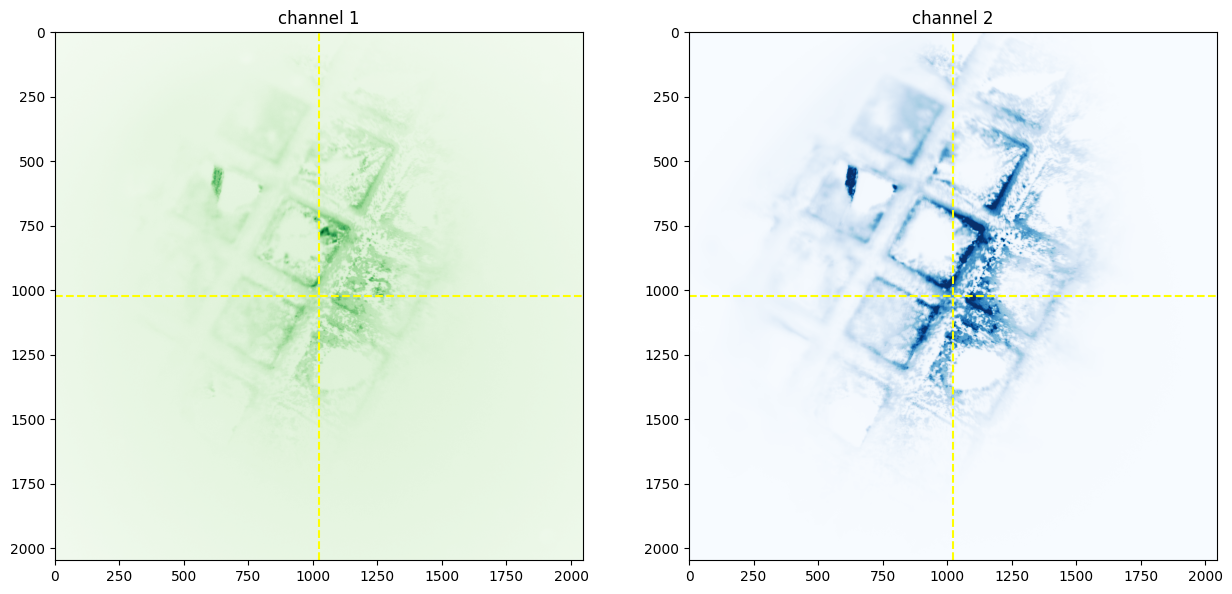

..\2023-05-08-04-12-48-228031PM.tif
(2048, 2048, 2)
[1, 2]


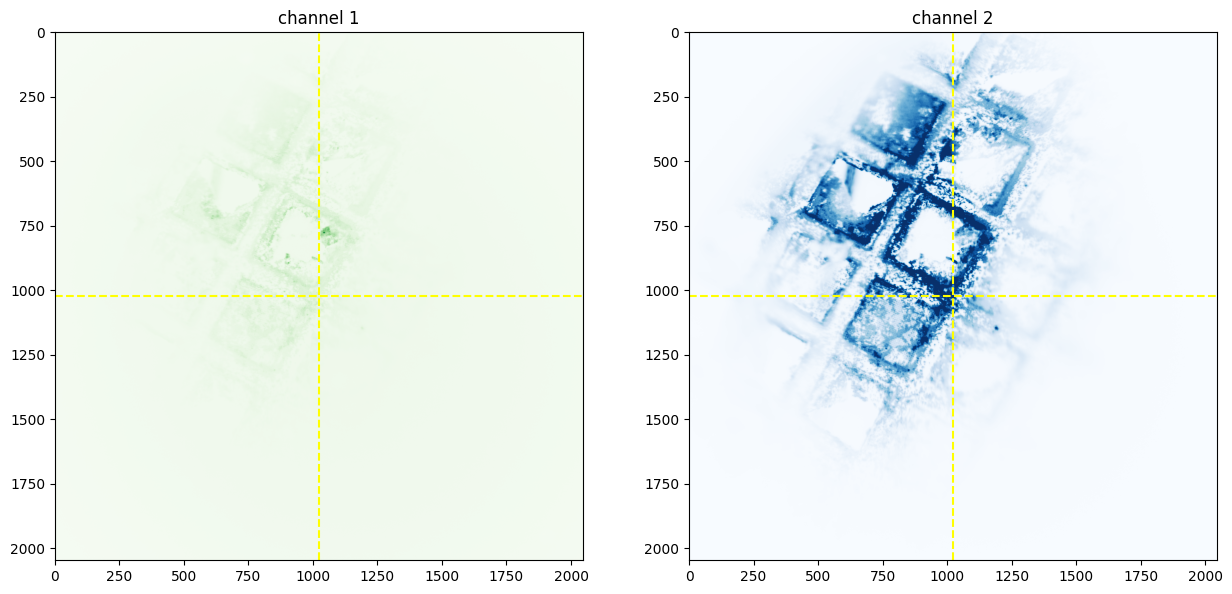

..\2023-05-08-04-12-54-192708PM.tif
(2048, 2048, 2)
[1, 2]


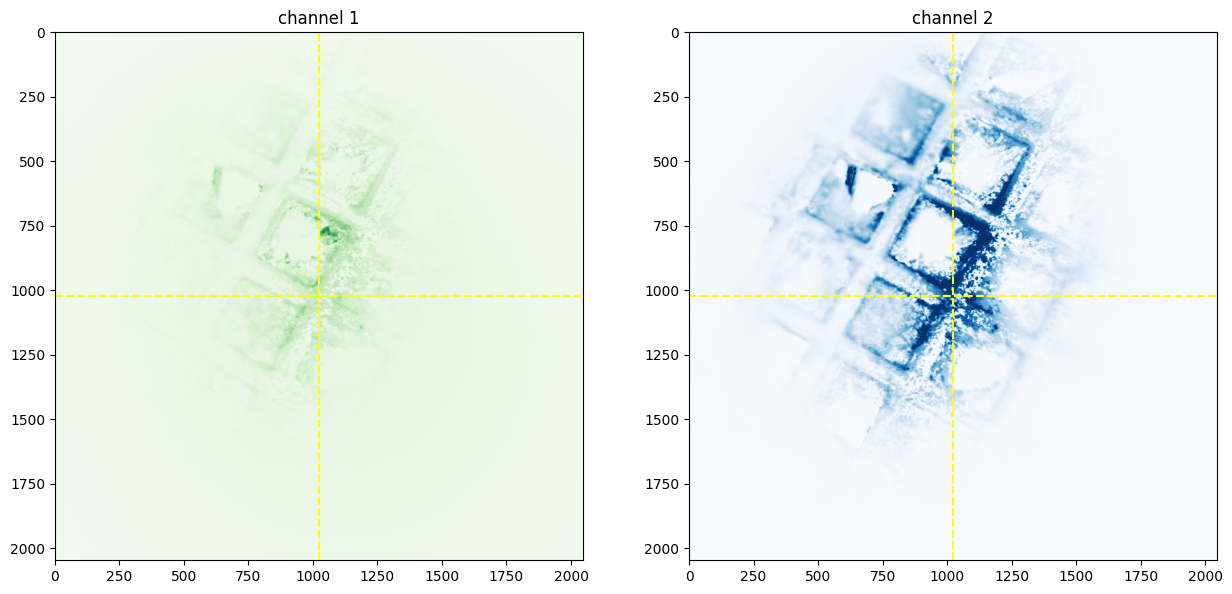

..\2023-05-08-04-12-59-634773PM.tif
(2048, 2048, 2)
[1, 2]


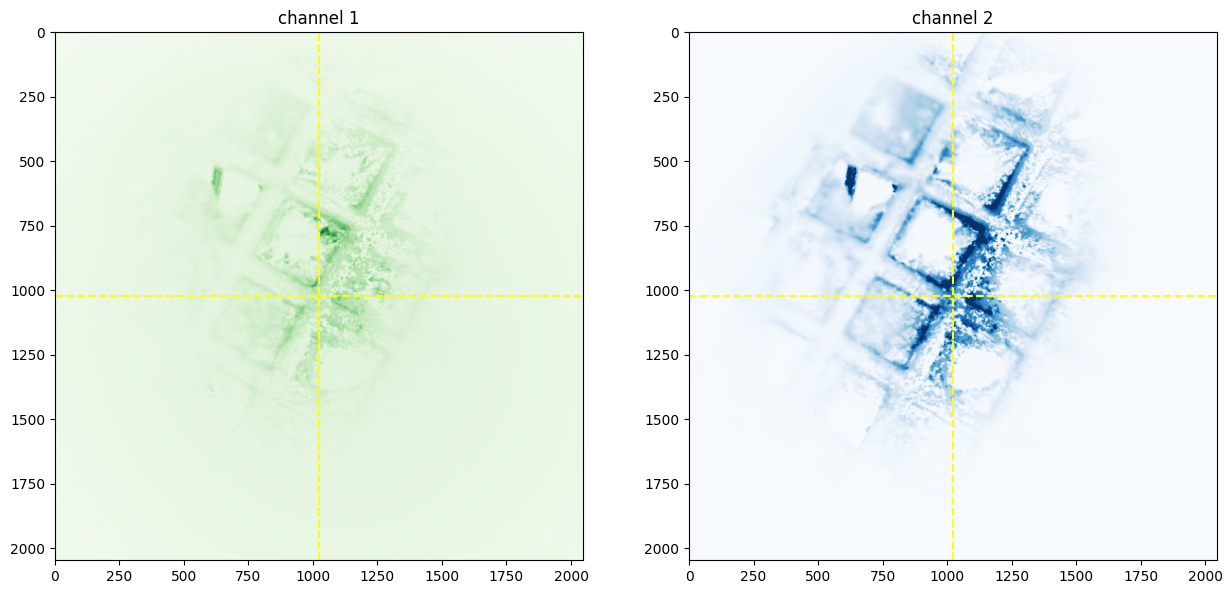

..\2023-05-08-04-13-05-080224PM.tif
(2048, 2048, 2)
[1, 2]


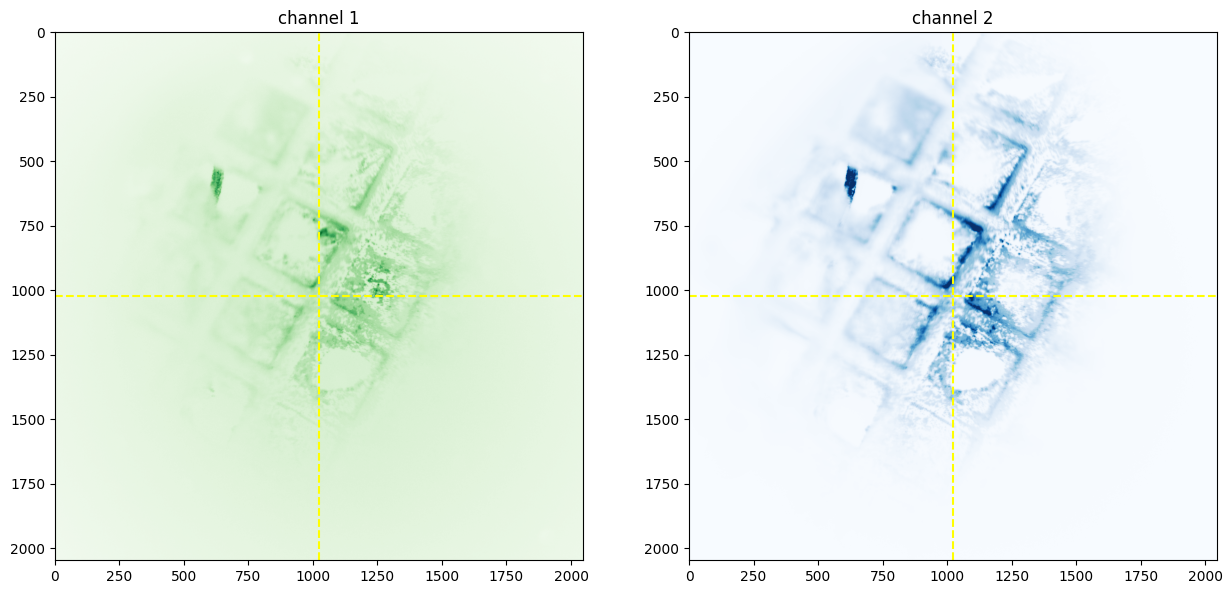

..\2023-05-08-04-13-10-530642PM.tif
(2048, 2048, 2)
[1, 2]


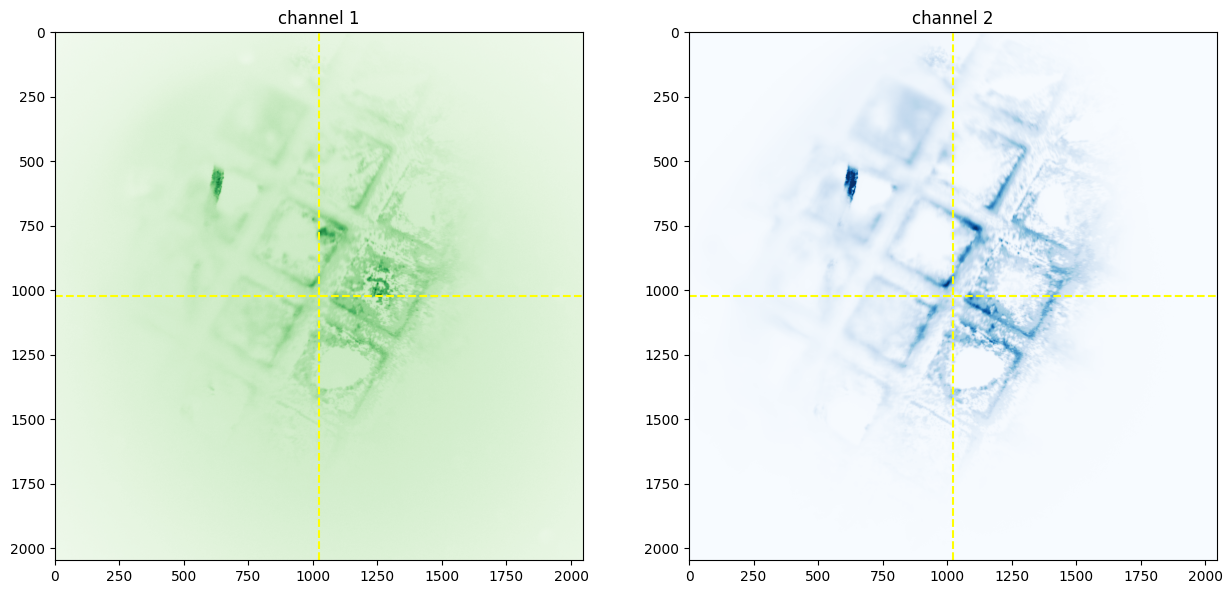

..\2023-05-08-04-13-15-972085PM.tif
(2048, 2048, 2)
[1, 2]


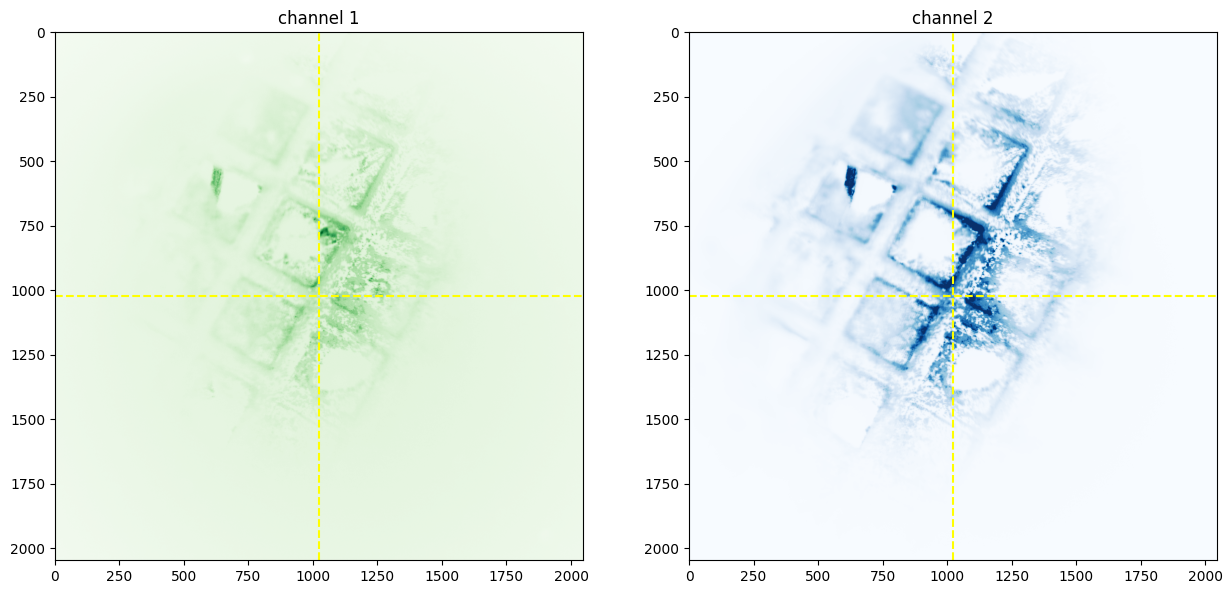

In [10]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from openlm.structures import LightImage

import glob
import os

# path = r"D:\David\piescope_dev\tile"
path = "../"
filenames = sorted(glob.glob(os.path.join(path, "2023-05-08-04-1*.tif")))

for fname in filenames:
    img = LightImage.load(fname)

    # subplots
    fig, axs = plt.subplots(1, img.data.shape[2], figsize=(15, 10))

    for i, channels in enumerate(img.metadata.channels):
        cmap = "Greens" if i == 0 else "Blues"
        axs[i].imshow(img.data[:, :, i], cmap=cmap)
        axs[i].set_title(f"channel {channels}")

        #centre crosshair, dashed line
        axs[i].axvline(img.data.shape[0]//2, linestyle="--", color="yellow")
        axs[i].axhline(img.data.shape[1]//2, linestyle="--", color="yellow")
    print(fname)
    print(img.data.shape)
    print(img.metadata.channels)

    plt.show()

## Microscope State

In [1]:
%load_ext autoreload
%autoreload 2

import logging

from openlm import utils
from openlm import config as cfg
import os

from fibsem import utils as fibsem_utils


import os
from openlm import utils
from openlm import config
from openlm.structures import ImageMode, SynchroniserMessage, ImageSettings, DetectorSettings
import time
import logging
import numpy as np
from PIL import Image

from dataclasses import dataclass
from openlm.structures import (LaserSettings, ImageMode, TriggerEdge, TriggerSource, 
    DetectorSettings, ObjectiveSettings, LightImage, LightImageMetadata)

from openlm.workflow import test_acq


In [2]:
CFG_PATH = os.path.join(cfg.BASE_PATH, "config", "piedisc.yaml")
microscope, settings = utils.setup_session(config_path=CFG_PATH)
microscope.fibsem_microscope, microscope.fibsem_settings = fibsem_utils.setup_session()

2023-05-08 14:17:41,260 — root — INFO — import_hardware_modules:205 — imported laser <class 'openlm.lasers.89north.ldi.LdiLaser'>
2023-05-08 14:17:41,261 — root — INFO — import_hardware_modules:205 — imported laser_controller <class 'openlm.lasers.89north.ldi.LdiLaserController'>
2023-05-08 14:17:41,286 — root — INFO — import_hardware_modules:205 — imported detector <class 'openlm.detectors.hamamatsu.hamamatsu.HamamatsuOrcaFlash4'>
2023-05-08 14:17:41,292 — root — INFO — import_hardware_modules:205 — imported objectives <class 'openlm.objectives.smaract.SMARACT.SMARACTObjectiveStage'>
2023-05-08 14:17:41,296 — root — INFO — import_hardware_modules:205 — imported synchronisers <class 'openlm.synchronisers.arduino.leonardo.ArduinoLeonardo'>
2023-05-08 14:17:41,396 — root — INFO — connect:40 — DCAM-API initialized
2023-05-08 14:17:41,399 — root — INFO — connect:22 — Connecting to objective stage.
2023-05-08 14:17:41,402 — root — INFO — connect:21 — Connecting to Arduino Leonardo synchroni

In [3]:
# SINGLE IMAGE



# what is a workflow
# a list of workflow steps

# what is a workflow step
# a function to run




In [ ]:
import glob
